
## Project:  Allstate Claims Severity
#### Author:   Joshep Downs, James Peng, Megan Pera, Diana Rodenberger 
#### Purpose:  Predicting cost and severity of claims for AllState
#### Created:  10/29/2016

### Team name in Kaggle: UCB_207_1

## Link to Leaderboard
https://www.kaggle.com/c/allstate-claims-severity/leaderboard


In [2]:
%matplotlib inline
import unittest

# General libraries.
import re, os, sys
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
#from sklearn.feature_extraction import 
from sklearn import preprocessing

from sklearn.utils import shuffle

from sklearn.metrics import mean_absolute_error

from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## ETL 

 1) Extract data and load into dataframe
 
 2) Create dummy variables for categorical variables
 
 3) Transform the variable 'loss'
 
 4) Create training datasets and development datasets.

In [5]:

df_data = pd.read_csv('./data_in/train.csv')

In [6]:
#split data frame into categorical variables, continous variables (including all 'contx' variables and 'loss') and ids

cat_cols=[]
cont_cols=[]
for c in df_data.columns:
    if c.find('cat') >=0: # -1: substring not found, >=0, starting index
        cat_cols.append(c)
    elif c.find('cont')>=0 or c.find('loss')>=0:
        cont_cols.append(c)

df_cont_vars = df_data[cont_cols]
        
#convert categorical variables into dummy variables
df_dummy_vars=pd.get_dummies(df_data[cat_cols])

#create dataset with predictors
X = pd.concat([df_dummy_vars, df_cont_vars], axis=1)
#create dataset with dependent variable
y = np.log10(df_data.loss)
#create additioanl dataset with claim ids
id = df_data.id


X_train, X_dev, y_train, y_dev, id_train, id_dev = train_test_split( X, y, id, test_size=0.33, random_state=1)

In [7]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_dev shape: ',X_dev.shape)
print('y_dev shape: ',y_dev.shape)


X_train shape:  (126173, 1154)
y_train shape:  (126173,)
X_dev shape:  (62145, 1154)
y_dev shape:  (62145,)


### Data Exploration of Continous Variables

More work needs to be done in this section

1) Check the distribution.

2) Check for correlation.

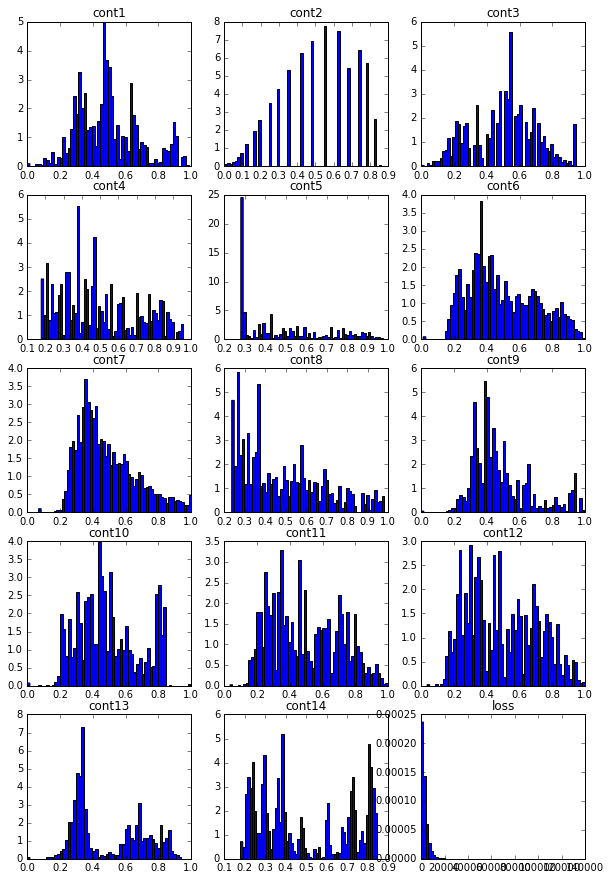

In [5]:
#function to plot histograms of continous variables
def PlotHisContinousVars(df):

    plt.subplots(5,3, figsize=(10,15))
    jj = 0
    for column_name in df.columns:
        jj+=1
        plt.subplot(5,3,jj).hist(df[column_name],normed=True, bins=60)
        plt.subplot(5,3,jj).set(title=column_name)
    plt.show()
    

#### TODO: more data exploration of continous variables

### Model 1: Linear Regression with dummy variables using RIDGE

We will try 3 different values of alpha

TODO: Find optimal values of alpha and other hyper-parameters

In [24]:
from sklearn.linear_model import LinearRegression

# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [41]:
### function to define Mean Absolute Error

def EstimateMEARidge(alpha, X_train,y_train,X_test, y_test):
    
    lr = linear_model.Ridge(alpha=alpha, normalize=True)

    # Train the model using the training sets
    lr.fit(X_train, y_train)

    # predict dev set
    preds = lr.predict(X_test)
   
    s = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error')
    
    print ('Regression - Ridge with alpha: ', alpha)

    print('mean_absolute_error on training data: {0}'.format(s))

    mae = mean_absolute_error(y_test, preds)
    print('mean_absolute_error on dev data {0}'.format(mae))
    

#### alpha =0.00001

In [42]:
pd.options.mode.chained_assignment = None

EstimateMEARidge(alpha=0.00001,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression - Ridge with alpha:  1e-05
mean_absolute_error on training data: [-0.11749056 -0.11727949 -0.11695215]
mean_absolute_error on dev data 0.11675829309188217


#### alpha =0.001

In [43]:
pd.options.mode.chained_assignment = None


EstimateMEARidge(alpha=0.001,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression - Ridge with alpha:  0.001
mean_absolute_error on training data: [-0.11752435 -0.11733484 -0.11699271]
mean_absolute_error on dev data 0.11680815150989424


#### alpha =0.1

In [44]:
pd.options.mode.chained_assignment = None


EstimateMEARidge(alpha=0.1,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression - Ridge with alpha:  0.1
mean_absolute_error on training data: [-0.12348621 -0.12336825 -0.12321482]
mean_absolute_error on dev data 0.12334083183190424


The following are the baseline scores submitted for the competition

mean_absolute_error on training data: [-0.19872471 -0.19753498 -0.19821047]

mean_absolute_error on test data 0.198086964004104


### Predict the Test Dataset

 1) Extract data and load into dataframe
 
 2) Create dummy variables for categorical variables
 
 3) Predict loss based on 'best' model previously found : Ridge with alpha= 0.00001


In [3]:
df_test = pd.read_csv('./data_in/test.csv')

In [4]:
test_cat_cols=[]
test_cont_cols=[]
for c in df_test.columns:
    if c.find('cat') >=0: # -1: substring not found, >=0, starting index
        test_cat_cols.append(c)
    elif c.find('cont')>=0 or c.find('loss')>=0:
        test_cont_cols.append(c)

test_df_cont_vars = df_test[test_cont_cols]
        
#convert categorical variables into dummy variables
test_df_dummy_vars=pd.get_dummies(df_test[test_cat_cols])

#create dataset with predictors
X_test = pd.concat([test_df_dummy_vars, test_df_cont_vars], axis=1)
id_test = df_test.id


In [9]:
print(X_test.shape)
print(X_train.shape)

(125546, 1116)
(126173, 1154)


## Important note:

The following code does not work because X_train has less variables than X_test.
I assume that the train data has more categories in some categorical variables than the test data; thus, when we tranform the categorical variables in the test data to dummy variables then we get less dummy variables than in the train set. 

TODO:
I need to fix this, probably just adding empty values to those dummy variables that only exist in the train data.


In [47]:
#id_train, x_train,  y_train = shuffle( df_train.id, df_train[col] , df_train.loss, random_state=0)

pd.options.mode.chained_assignment = None

lr = linear_model.Ridge(alpha=0.00001, normalize=True)

lr.fit(X_train, y_train)

#use same linear model previously fit with training data
y_test_log_pred = lr.predict(X_test)

# convert from log10 scale to linear scale 
y_test_pred = np.power(10, y_test_log_pred)

# assamble the final dataset
y_test_predicted_loss=pd.DataFrame(id_test)

y_test_pred_df=pd.DataFrame({"loss": y_test_pred})

y_test_predicted_loss=pd.concat([y_test_predicted_loss,y_test_pred_df], axis=1)


#check final output
print("number of ids: ", len(id_test))
print("number of rows in predicted test set: ",len(y_test_predicted_loss) )

#create csv file to submit
y_test_predicted_loss.to_csv('./data_out/AllState_lr_ridge.csv', encoding='utf-8', index=False)


ValueError: shapes (125546,1116) and (1154,) not aligned: 1116 (dim 1) != 1154 (dim 0)